In [1]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import seaborn as sns
sns.set()

2022-03-02 17:28:44.506320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 17:28:44.506341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
#OptimalXAI = np.load("OptimalXAIFeature.npy")
# now something different
OptimalXAI = np.load("XAI_modes.npy")
OptimalXAI

array([[ 0, 11],
       [ 1, 40],
       [ 2, 37],
       [ 3, 41],
       [ 4, 16],
       [ 5, 16],
       [ 6, 14],
       [ 7, 16]])

### Train NN with all relevant features

For this, we need one-hot encoded y

In [3]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{37, 40, 41, 11, 14, 16}
(5251, 6)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


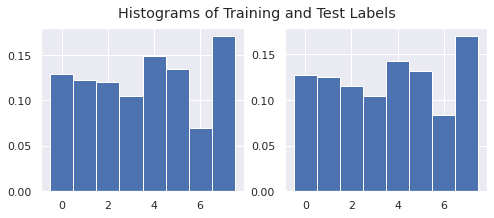

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [5]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

6 8
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1792      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1024)              132096    
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 8)              

2022-03-02 17:28:48.728656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-02 17:28:48.728675: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 17:28:48.728692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BARDEEN): /proc/driver/nvidia/version does not exist
2022-03-02 17:28:48.728938: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 1s 27ms/step - loss: 2.0343 - accuracy: 0.1967 - val_loss: 2.0010 - val_accuracy: 0.1808
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 1.9521 - accuracy: 0.2177 - val_loss: 1.9183 - val_accuracy: 0.2160
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 1.8534 - accuracy: 0.2632 - val_loss: 1.8189 - val_accuracy: 0.2860
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 1.7507 - accuracy: 0.3360 - val_loss: 1.6924 - val_accuracy: 0.3729
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 1.6166 - accuracy: 0.4389 - val_loss: 1.5407 - val_accuracy: 0.4531
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 1.4556 - accuracy: 0.5111 - val_loss: 1.3800 - val_accuracy: 0.5037
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 1.2949 - accuracy: 0.5708 - val_loss: 1.2185 - val_accuracy: 0.5674
Epoch 8/100


In [7]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.7882285054818234


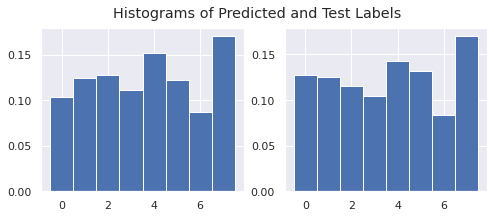

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Now with some other features

In [9]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [10]:
TestNN(54321)

0.7166762839007501

In [11]:
TestNN()

0.7299480669359493

In [12]:
Runs = 100
NN_comparison = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    print(i,s,Test_Score)
    NN_comparison[i] = Test_Score


0 [5206] 0.7559145989613387
1 [8676] 0.7362954414310444
2 [2446] 0.7697634160415464
3 [2594] 0.7743796884016156
4 [0] 0.7489901904212348
5 [7221] 0.7974610502019619
6 [6887] 0.790536641661858
7 [7580] 0.7888055395268321
8 [30] 0.7137911136757069
9 [7699] 0.7080207732256203
10 [4222] 0.7501442585112522
11 [6242] 0.7663012117714946
12 [1070] 0.8343912290825158
13 [6397] 0.7559145989613387
14 [7177] 0.7651471436814772
15 [2956] 0.7703404500865552
16 [395] 0.7541834968263128
17 [5141] 0.7507212925562609
18 [8748] 0.7963069821119446
19 [6897] 0.7443739180611656
20 [5977] 0.7795729948066936
21 [5705] 0.7674552798615119
22 [4016] 0.7645701096364685
23 [2914] 0.7472590882862089
24 [142] 0.7674552798615119
25 [657] 0.7120600115406809
26 [9479] 0.6803231390652048
27 [4210] 0.6982111944604732
28 [8513] 0.7351413733410271
29 [9173] 0.7022504327755338
30 [9637] 0.7010963646855164
31 [6801] 0.7599538372763993
32 [3333] 0.6739757645701097
33 [921] 0.6993652625504905
34 [1677] 0.7547605308713214
35 [5

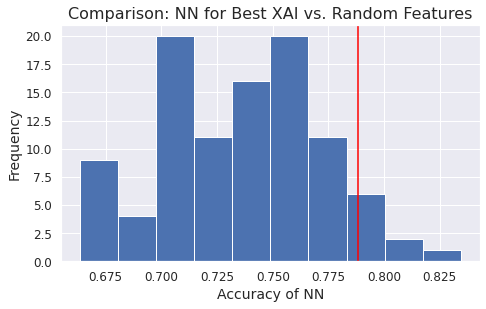

In [13]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
plt.hist(NN_comparison)
plt.axvline(Accuracy_BestXAI,
            c="red")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Comparison_RandomFeatures_vs_XAImode_100NN",dpi=600)
plt.show()

In [15]:
np.median(NN_comparison),np.mean(NN_comparison), Accuracy_BestXAI

(0.7365839584535487, 0.7345758799769186, 0.7882285054818234)